## ATAC + MULTIOME (females september 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
library(Signac)
library(cicero)

library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)
library(Seurat)
library(GenomeInfoDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

In [7]:
%%R 

writeLines(capture.output(sessionInfo()), "./sessionInfo.txt")

**Load data**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/"
experiment_prefix = 'females_'

In [9]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Setup of cisTopic**

In [11]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata

View of AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

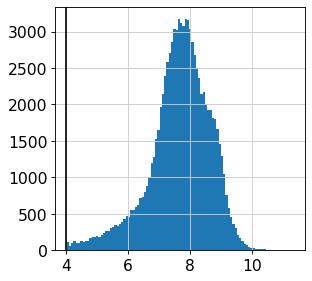

In [32]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=4, color="black")

**Convert anndata to SingleCellExperiment**

In [33]:
%%R -i adata -i outdir -i experiment_prefix
adata
#saveRDS(adata, paste0(outdir, experiment_prefix, "_SCE.RDS"))

class: SingleCellExperiment 
dim: 153356 90920 
metadata(0):
assays(2): X binary_raw
rownames(153356): chr1:816774-817439 chr1:817726-818992 ...
  chrX:155955795-155956326 chrY:6533757-6534449
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(90920): 13-AAACAGCCAAGCGATG-1 13-AAACAGCCACTAGCGT-1 ...
  12-TTTGTGTGTTAACCGT-1 12-TTTGTGTGTTAAGTCC-1
colData names(11): cellatac_clusters n_genes_by_counts ...
  multiome_GermCells multiome_Somatic
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [34]:
%%R -i outdir -i experiment_prefix

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_initialized_cisTopic.RDS"))

Run cisTopic with farm resources as VM doesn't have enough CPU/memory

In [36]:
#%%R -i outdir -i experiment_prefix

#topics_vec <- c(25:45)
#cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
#                                   seed = 1712, 
#                                   nCores = 21, 
#                                   iterations = 500
#                                  )
#
#saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

In [13]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

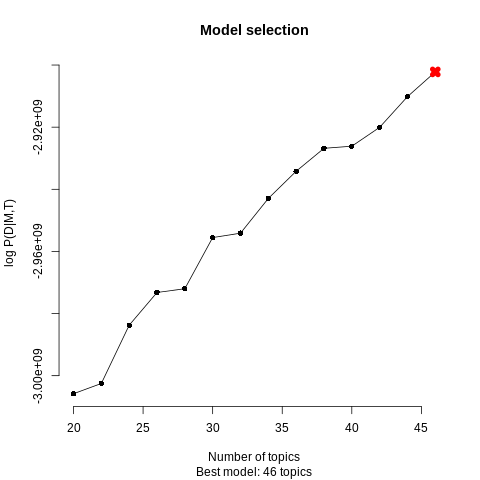

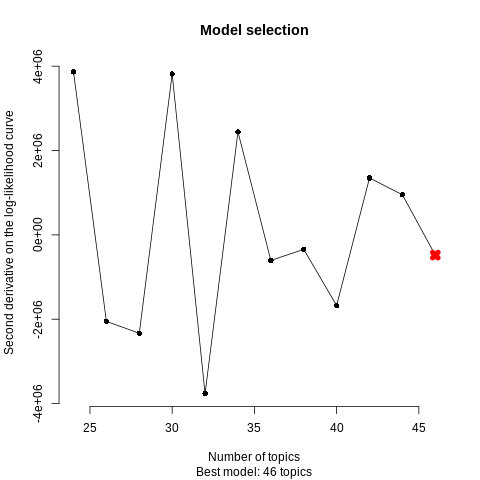

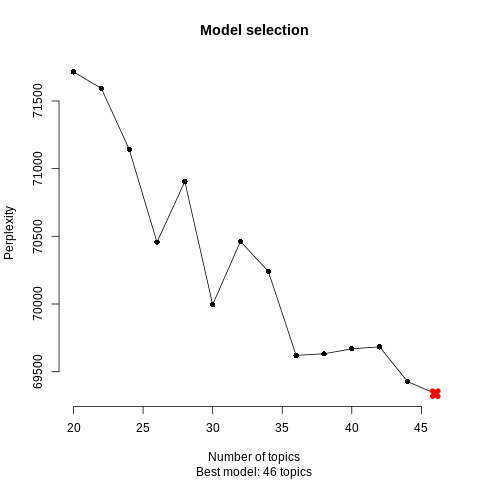

In [14]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = "maximum")

In [39]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    46 90920


In [40]:
topicXcell

array([[0.00714286, 0.03431373, 0.02617839, ..., 0.00058904, 0.00273372,
        0.00469816],
       [0.00102041, 0.00245098, 0.03647571, ..., 0.00043836, 0.00150186,
        0.00188976],
       [0.00076531, 0.00931373, 0.00377085, ..., 0.00067123, 0.00057374,
        0.00209974],
       ...,
       [0.03545918, 0.00735294, 0.02146483, ..., 0.00245205, 0.00369558,
        0.00175853],
       [0.00102041, 0.01176471, 0.00420595, ..., 0.00324658, 0.00693554,
        0.00186352],
       [0.00433673, 0.00294118, 0.01247281, ..., 0.00079452, 0.00337496,
        0.00031496]])

In [41]:
adata.obsm['X_cistopic_46'] = topicXcell.T

**Visualize dimensionality reduction results**

In [42]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_cistopic_46")

In [43]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1.2)

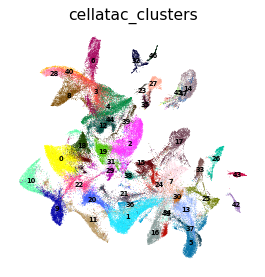

In [44]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [47]:
colors = ['royalblue', 'orange', 'green', 'lightgrey', 'red', 'orchid',  'brown', 'pink', 'yellowgreen', 
                'deepskyblue']

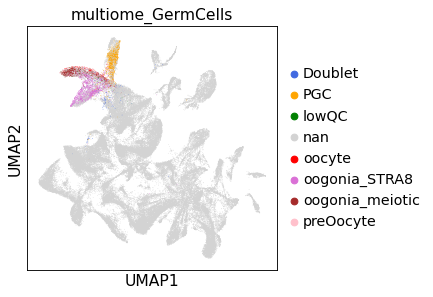

In [48]:
sc.pl.umap(adata, color = ['multiome_GermCells'], palette = colors)

In [53]:
colors2 = ['royalblue', 'orange', 'green', 'red', 'orchid', 'brown', 'pink', 'yellowgreen', 
                'deepskyblue',  'lightgrey',]

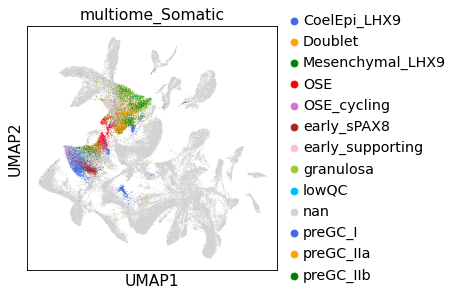

In [54]:
sc.pl.umap(adata, color = ['multiome_Somatic'], palette = colors2)

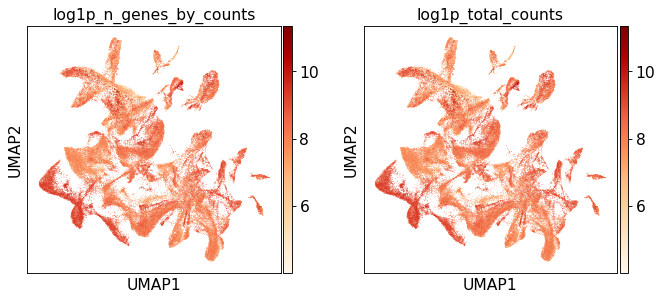

In [55]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [56]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

08    12913
01    12527
07     8901
03     8668
09     8394
11     5326
17     5060
12     4974
06     4878
02     4722
05     3458
13     2920
14     2917
16     2447
15     1643
04     1172
Name: code, dtype: int64

In [59]:
# Sample from code 
sample_dictionary = {'01' : 'HCA_F_GON10535399', '02' : 'HCA_F_GON10687818', '03' : 'FCA_GND8046539', 
                    '04' : 'FCA_GND8768483', '05' : 'FCA_GND8768484', '06' : 'FCA_GND8768485', 
                     '07' : 'HD_F_GON9479873', '08' : 'HD_F_GON9479874', '09' : 'HD_F_GON9479875', 
                     '11' : 'HD_F_GON9883959', '12' : 'HD_F_GON9883960', 
                    '13' : 'FCA_GND10288176', '14' : 'FCA_GND10288177', '15' : 'FCA_GND10288178', 
                    '16' : 'FCA_GND10288179', '17' : 'FCA_GND10288180'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

HD_F_GON9479874      12913
HCA_F_GON10535399    12527
HD_F_GON9479873       8901
FCA_GND8046539        8668
HD_F_GON9479875       8394
HD_F_GON9883959       5326
FCA_GND10288180       5060
HD_F_GON9883960       4974
FCA_GND8768485        4878
HCA_F_GON10687818     4722
FCA_GND8768484        3458
FCA_GND10288176       2920
FCA_GND10288177       2917
FCA_GND10288179       2447
FCA_GND10288178       1643
FCA_GND8768483        1172
Name: sample, dtype: int64

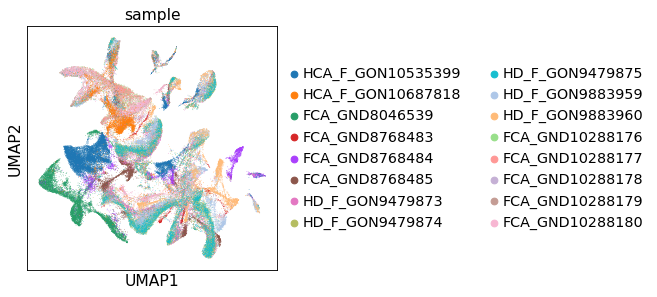

In [60]:
sc.pl.umap(adata, color = 'sample')

In [61]:
sex_dictionary = {'HCA_F_GON10535399' : 'female', 'HCA_F_GON10687818' : 'female', 'FCA_GND8046539' : 'female', 
                    'FCA_GND8768483' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768485' : 'female', 
                     'HD_F_GON9479873' : 'female', 'HD_F_GON9479874' : 'female', 'HD_F_GON9479875' : 'female', 
                'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female', 
                   'FCA_GND10288176' : 'female', 'FCA_GND10288177' : 'female', 'FCA_GND10288178' : 'female', 
                    'FCA_GND10288179' : 'female', 'FCA_GND10288180' : 'female'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    90920
Name: sex, dtype: int64

In [63]:
stage_dictionary = {'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW', 
                   'FCA_GND10288176' : '21 PCW', 
                 'FCA_GND10288177' : '21 PCW', 'FCA_GND10288178' : '14 PCW', 'FCA_GND10288179' : '20 PCW', 
                 'FCA_GND10288180' : '20 PCW', 'HCA_F_GON10535399' : '8.6 PCW', 'HCA_F_GON10687818' : '13 PCW'}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

14 PCW     24122
13 PCW     13623
8.6 PCW    12527
8 PCW      12126
21 PCW     10811
20 PCW      7507
18 PCW      5326
9 PCW       4878
Name: stage, dtype: int64

In [64]:
individual_dictionary = {'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58', 
                         'FCA_GND10288176' : 'Hrv58', 
                 'FCA_GND10288177' : 'Hrv58', 'FCA_GND10288178' : 'Hrv39', 'FCA_GND10288179' : 'Hrv65', 
                 'FCA_GND10288180' : 'Hrv65', 'HCA_F_GON10535399' : 'Hrv92', 'HCA_F_GON10687818' : 'Hrv91'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv50    21307
Hrv92    12527
Hrv58    10811
Hrv49     8901
F81       8668
Hrv65     7507
Hrv59     5326
Hrv13     4878
Hrv91     4722
Hrv12     3458
Hrv39     1643
Hrv11     1172
Name: individual, dtype: int64

#### Plot metadata information

... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


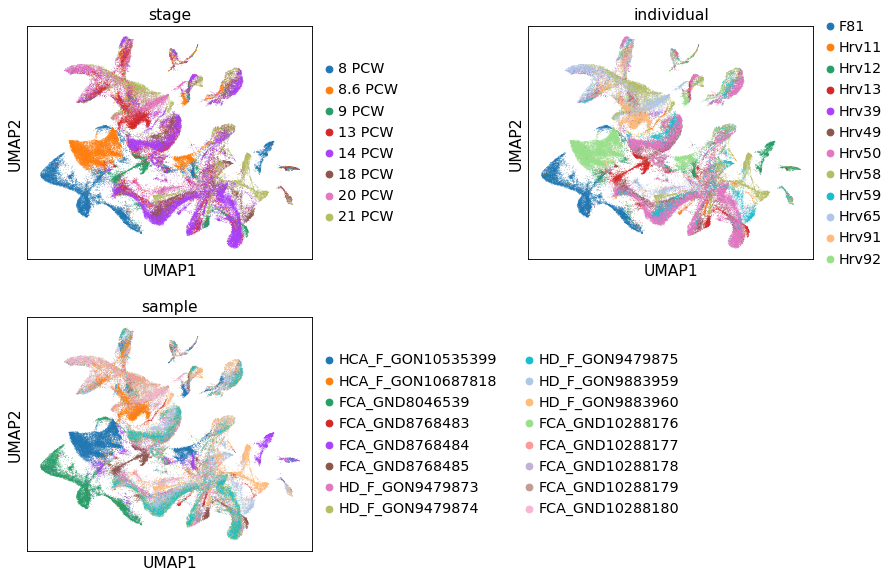

In [65]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:
𝑃(𝑟𝑖|𝑐𝑗)=∑𝑘=1𝐾𝑃(𝑟𝑖|𝑇𝑘)𝑃(𝑇𝑘|𝑐𝑗)
 
where

 * 𝑃(𝑟𝑖|𝑐𝑗)  is the probability of region i in cell j,
 * 𝑃(𝑟𝑖|𝑇𝑘)  is the probability of region i in topic k, and
 * 𝑃(𝑇𝑘|𝑐𝑗)  is the probability of topic k in cell j.

In [16]:
#%%R 

#install.packages("bigmemory")

In [15]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [16]:
%%R
dim(p_mat)

[1] 153356  90920


In [17]:
p_mat

array([[3.54988199e-06, 4.33240585e-06, 2.08761681e-06, ...,
        2.90704504e-06, 3.64896827e-06, 1.04068447e-05],
       [3.86057809e-06, 2.98485534e-06, 6.83665259e-06, ...,
        1.63895265e-06, 1.59669687e-06, 9.33058136e-07],
       [2.93829294e-05, 3.47728963e-05, 2.15731544e-05, ...,
        4.78071810e-05, 4.58682989e-05, 7.67604762e-05],
       ...,
       [2.23415943e-06, 1.56243239e-06, 6.36095468e-06, ...,
        1.40396711e-07, 1.58184028e-07, 4.85044828e-07],
       [1.75839136e-06, 1.16641938e-06, 5.02218442e-06, ...,
        6.08146988e-07, 5.59246735e-07, 7.18057615e-07],
       [1.68717505e-06, 1.09387936e-06, 6.27687235e-06, ...,
        9.41173588e-08, 4.12081569e-08, 2.80465792e-07]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [70]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [71]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [72]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  print("Got to here")
  print(typeof(length(all_peaks)))
  print(typeof(length(all_feats)))
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [73]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [74]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

[1] "Got to here"
[1] "integer"
[1] "integer"


In [75]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

### Alternative implementation of dot product between *adj_mat* and *p_mat*

In [76]:
print(np.__version__)

1.21.2


In [77]:
import math

#### adj_mat

In [78]:
rows_adj_mat = adj_mat.shape[0]
print(rows_adj_mat)
cols_adj_mat = adj_mat.shape[1]
print(cols_adj_mat)

16882
153356


In [79]:
a1 = adj_mat[0:math.ceil(rows_adj_mat/2), 0:math.ceil(cols_adj_mat/2)]
a2 = adj_mat[0:math.ceil(rows_adj_mat/2), math.ceil(cols_adj_mat/2):]
a3 = adj_mat[math.ceil(rows_adj_mat/2):, 0:math.ceil(cols_adj_mat/2)]
a4 = adj_mat[math.ceil(rows_adj_mat/2):, math.ceil(cols_adj_mat/2):]

In [80]:
print("a1 : {}\na2 : {}\na3 : {}\na4 : {}".format(a1.shape, a2.shape, a3.shape, a4.shape))

a1 : (8441, 76678)
a2 : (8441, 76678)
a3 : (8441, 76678)
a4 : (8441, 76678)


#### p_mat

In [81]:
rows_p_mat = p_mat.shape[0]
print(rows_p_mat)
cols_p_mat = p_mat.shape[1]
print(cols_p_mat)

153356
90920


In [82]:
b1 = p_mat[0:math.ceil(rows_p_mat/2), 0:math.ceil(cols_p_mat/2)]
b2 = p_mat[0:math.ceil(rows_p_mat/2), math.ceil(cols_p_mat/2):]
b3 = p_mat[math.ceil(rows_p_mat/2):, 0:math.ceil(cols_p_mat/2)]
b4 = p_mat[math.ceil(rows_p_mat/2):, math.ceil(cols_p_mat/2):]

In [83]:
print("b1 : {}\nb2 : {}\nb3 : {}\nb4 : {}".format(b1.shape, b2.shape, b3.shape, b4.shape))

b1 : (76678, 45460)
b2 : (76678, 45460)
b3 : (76678, 45460)
b4 : (76678, 45460)


#### Strassen matrix multiplication

In [84]:
c1 = np.add(a1.dot(b1), a2.dot(b3))

In [85]:
c1.shape

(8441, 45460)

In [86]:
c2 = np.add(a1.dot(b2), a2.dot(b4))

In [87]:
c2.shape

(8441, 45460)

In [88]:
c3 = np.add(a3.dot(b1), a4.dot(b3))

In [89]:
c3.shape

(8441, 45460)

In [90]:
c4 = np.add(a3.dot(b2), a4.dot(b4))

In [91]:
c4.shape

(8441, 45460)

In [92]:
c12 = np.concatenate((c1, c2), axis=1)

In [93]:
c12.shape

(8441, 90920)

In [94]:
c34 = np.concatenate((c3, c4), axis=1)

In [95]:
c34.shape

(8441, 90920)

In [96]:
gene_mat = np.concatenate((c12, c34), axis=0)

In [97]:
gene_mat.shape

(16882, 90920)

In [98]:
gene_mat

array([[3.67933895e-05, 4.20901575e-05, 3.04974238e-05, ...,
        5.23531786e-05, 5.11139640e-05, 8.81003791e-05],
       [2.93343069e-05, 3.08330845e-05, 4.54110603e-05, ...,
        2.91568449e-05, 2.66961548e-05, 4.81585977e-05],
       [2.93343069e-05, 3.08330845e-05, 4.54110603e-05, ...,
        2.91568449e-05, 2.66961548e-05, 4.81585977e-05],
       ...,
       [3.05281097e-05, 2.88410245e-05, 2.85024785e-05, ...,
        3.00442830e-05, 3.06926709e-05, 3.24550300e-05],
       [2.26806616e-05, 2.58000851e-05, 2.81157582e-05, ...,
        3.32670858e-05, 3.22468749e-05, 2.77289090e-05],
       [4.78544849e-05, 4.12665041e-05, 6.66997052e-05, ...,
        7.53286995e-05, 6.82146065e-05, 3.25001053e-05]])

In [99]:
# gene_mat = adj_mat.dot(p_mat) --> kills the kernel because both matrices need to be hold in memory 

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [100]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [101]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

gene_id
gene_name                    
RP5-857K21.4  ENSG00000230021
FAM41C        ENSG00000230368
TUBB8P11      ENSG00000234711
FAM166AP3     ENSG00000283040
RP11-54O7.16  ENSG00000272438

In [102]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(90920, 16882)

In [103]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 90920 × 16882
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [104]:
gene_adata.var_names_make_unique()

In [105]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_46'] = topicXcell.T

In [106]:
adata

AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'multiome_GermCells_colors', 'multiome_Somatic_colors', 'sample_colors', 'stage_colors', 'individual_colors'
    obsm: 'X_cistopic_46', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [107]:
del adata.layers['cistopic_p']

In [108]:
adata

AnnData object with n_obs × n_vars = 90920 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'multiome_GermCells_colors', 'multiome_Somatic_colors', 'sample_colors', 'stage_colors', 'individual_colors'
    obsm: 'X_cistopic_46', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [109]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [110]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [111]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_46")

In [112]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1.2)

**Plot markers per cell type from RNA-seq**

In [113]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

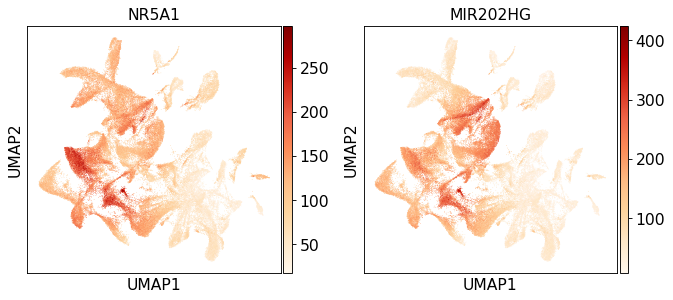

In [114]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1',  'MIR202HG'] , ncols = 3, color_map = 'OrRd')

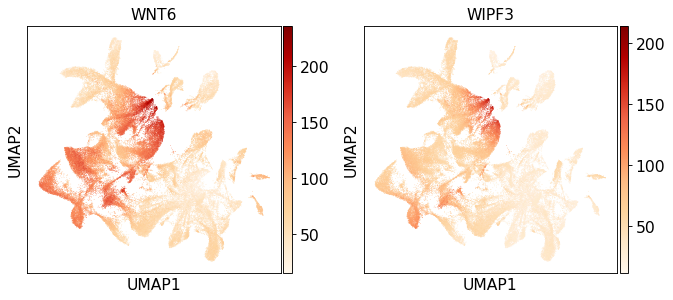

In [115]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

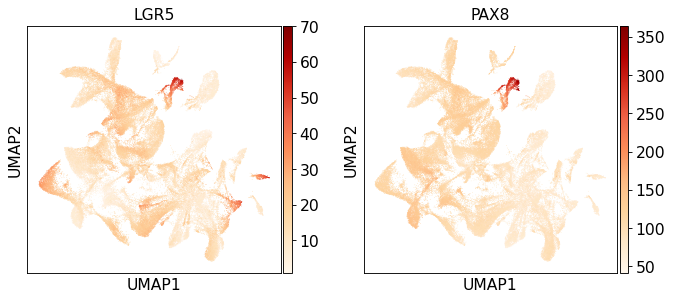

In [116]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

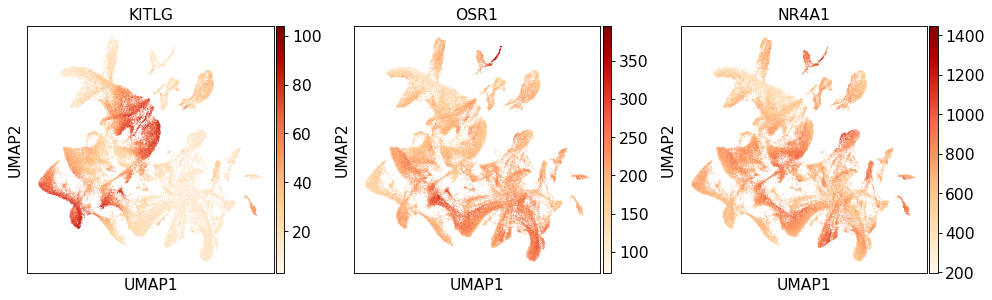

In [117]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

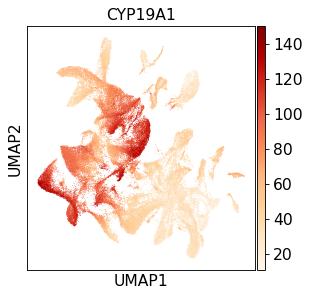

In [118]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

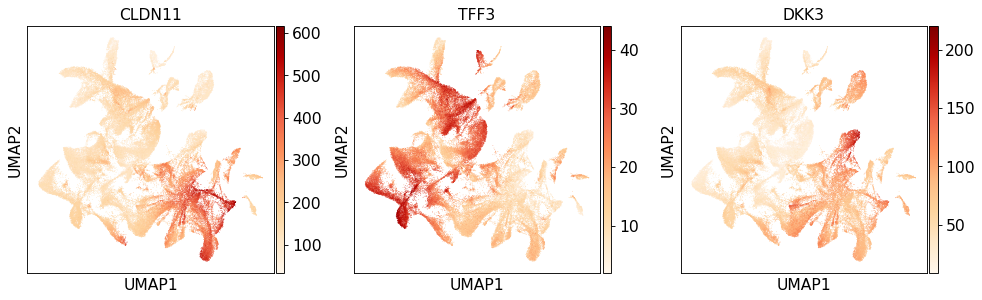

In [119]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

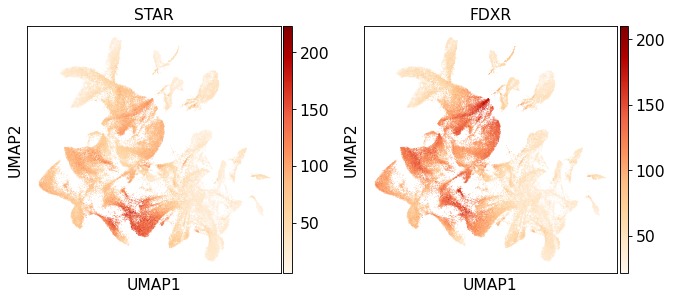

In [120]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

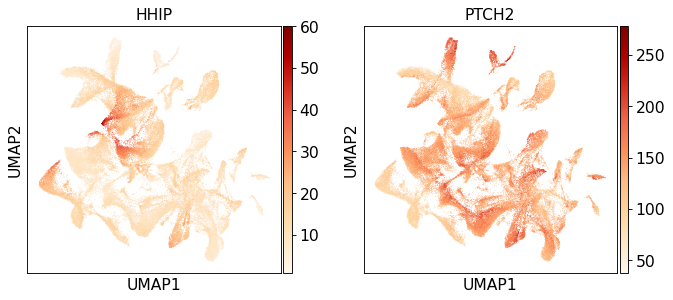

In [121]:
# Leydig lineage
sc.pl.umap(gene_adata, color = ['HHIP', 'PTCH2'], ncols = 3, color_map = 'OrRd')

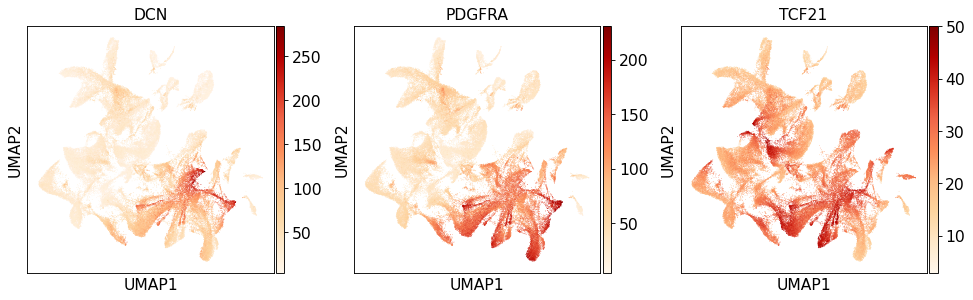

In [122]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

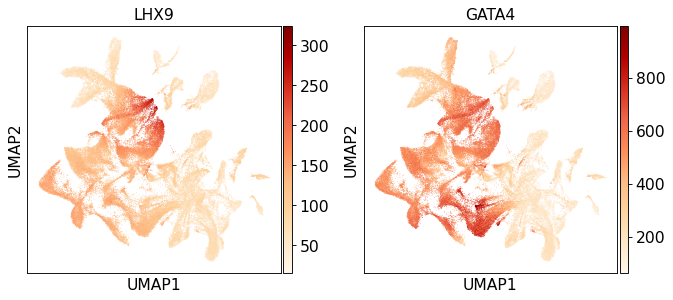

In [123]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

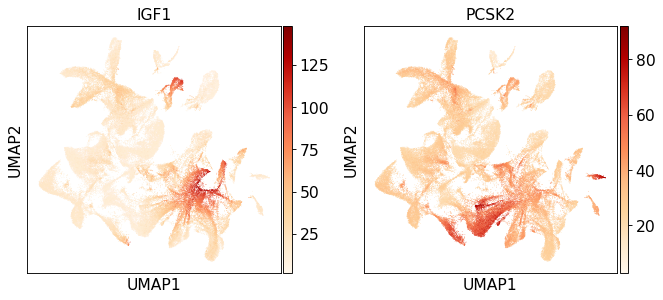

In [124]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

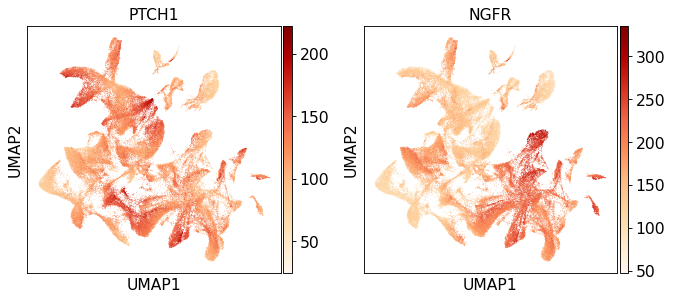

In [125]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

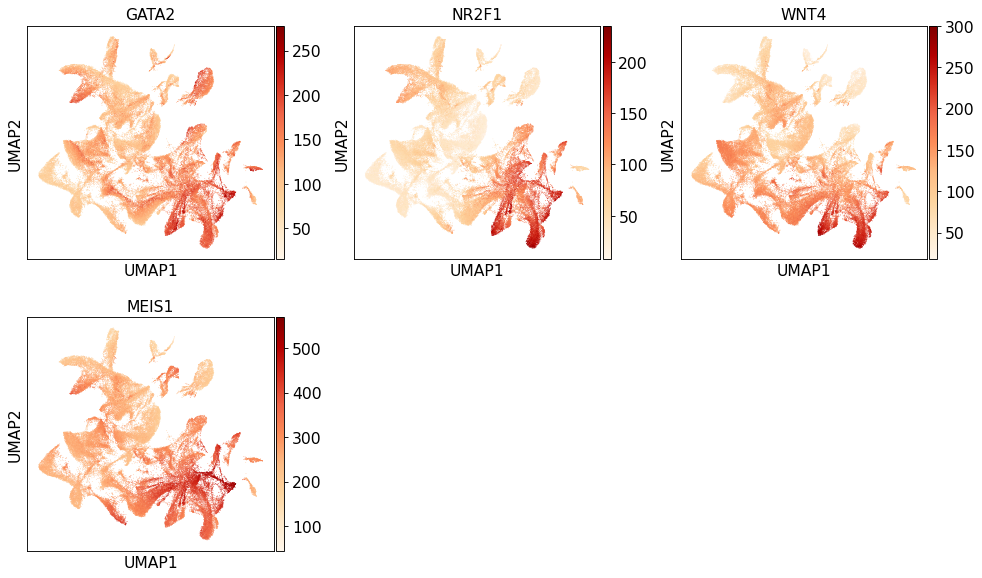

In [126]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

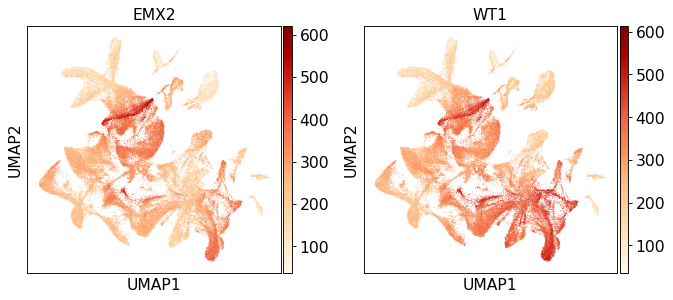

In [127]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

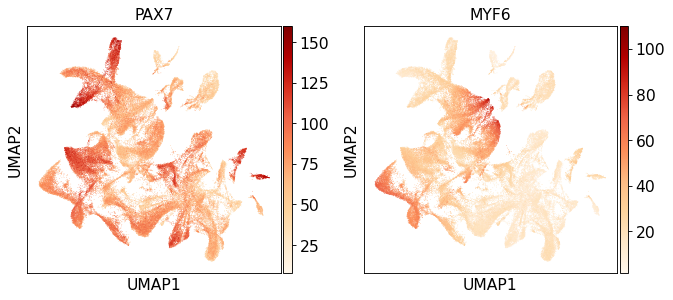

In [128]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

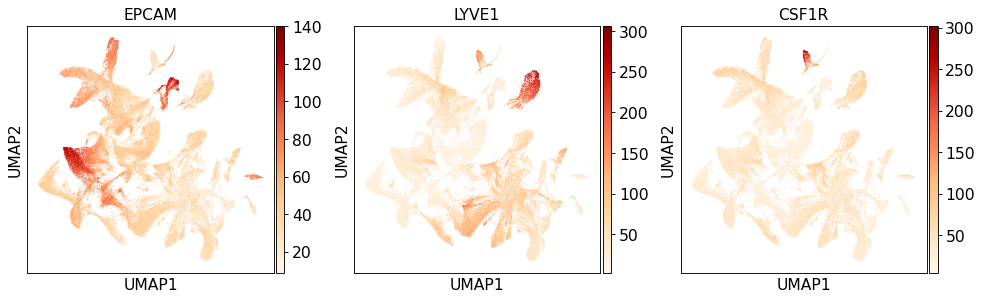

In [129]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

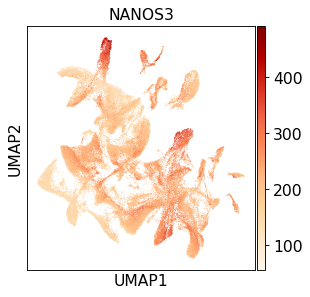

In [130]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

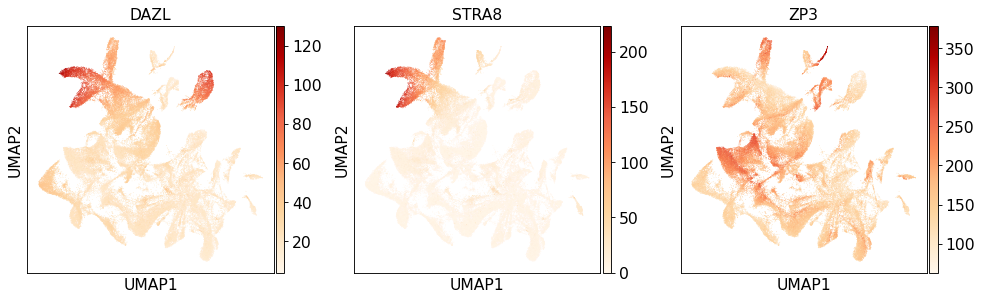

In [131]:
# Germ cells
sc.pl.umap(gene_adata, color = ['DAZL',  'STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

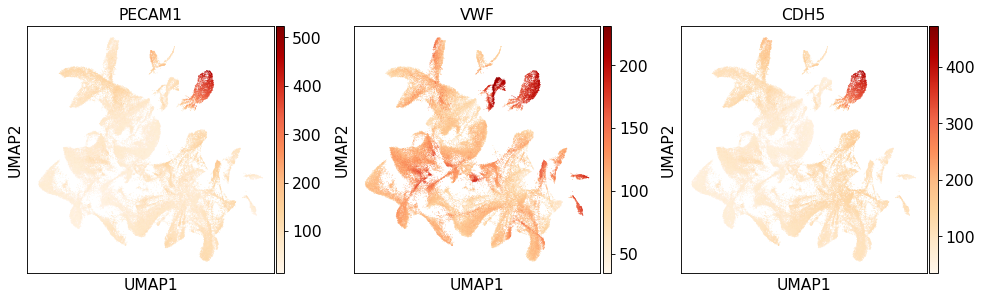

In [132]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

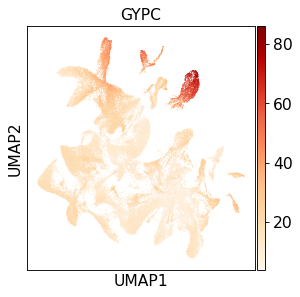

In [133]:
# Erythroid
sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

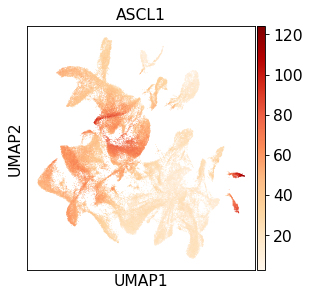

In [134]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

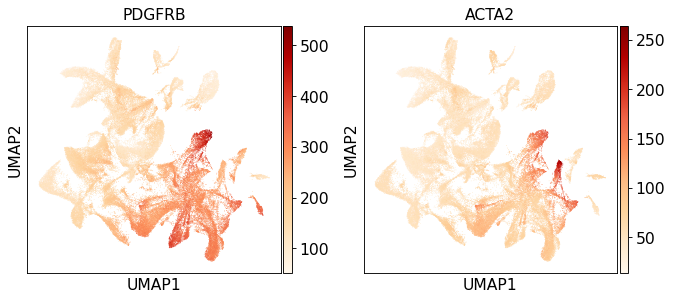

In [135]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [136]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

## Compute CCANs enriched in each cell type

In [18]:
p_mat_transpose = p_mat.T 

In [19]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

Peak  CCAN           peaks_formatted  peak_width  exon  \
1      chr1-1001453-1002077   671      chr1-1001453-1002077         625     0   
2    chr1-10020259-10021044   685    chr1-10020259-10021044         786     0   
3  chr1-100354898-100355211     2  chr1-100354898-100355211         314     0   
4  chr1-100357631-100358495     2  chr1-100357631-100358495         865     0   
5  chr1-100360580-100361253     2  chr1-100360580-100361253         674     0   

           gene_id  gene gene_name  annotation  promoter  tss_distance  \
1  ENSG00000187608     1     ISG15    promoter         1           307   
2              NaN     0       NaN  intergenic         0         11787   
3  ENSG00000079335     1    CDC14A      intron         0          2297   
4  ENSG00000079335     1    CDC14A      intron         0          5030   
5  ENSG00000079335     1    CDC14A      intron         0          7979   

   ENCODE_blacklist  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0

Workflow: 

 * Subset the cells x peaks matrix to keep only the peaks in CCANs
 * Create a new matrix: cell_type x CCANs 
 * Normalize new matrix by CCAN

In [20]:
peaksinCCANs = list(ccans['Peak'])

In [21]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

Trying to set attribute `.var` of view, copying.


peaks_formatted        chr1-816774-817439  chr1-817726-818992  \
13-AAACAGCCAAGCGATG-1            0.000004            0.000004   
13-AAACAGCCACTAGCGT-1            0.000004            0.000003   
13-AAACAGCCAGCCAGAA-1            0.000002            0.000007   
13-AAACAGCCATCCAGGT-1            0.000002            0.000009   
13-AAACATGCATCCCGCT-1            0.000002            0.000008   

peaks_formatted        chr1-826596-827807  chr1-869453-870256  \
13-AAACAGCCAAGCGATG-1            0.000029            0.000013   
13-AAACAGCCACTAGCGT-1            0.000035            0.000016   
13-AAACAGCCAGCCAGAA-1            0.000022            0.000015   
13-AAACAGCCATCCAGGT-1            0.000039            0.000028   
13-AAACATGCATCCCGCT-1            0.000030            0.000015   

peaks_formatted        chr1-874940-875858  chr1-876272-877438  \
13-AAACAGCCAAGCGATG-1            0.000009            0.000007   
13-AAACAGCCACTAGCGT-1            0.000008            0.000008   
13-AAACAGCCAGCCAGAA-1            0.000015            0.000016   
13-AAACAGCCATCCAGGT-1            0.000006            0.000012   
13-AAACATGCATCCCGCT-1            0.000004            0.000008   

peaks_formatted        chr1-886036-886944  chr1-902597-903054  \
13-AAACAGCCAAGCGATG-1            0.000004            0.000003   
13-AAACAGCCACTAGCGT-1            0.000003            0.000003   
13-AAACAGCCAGCCAGAA-1            0.000009            0.000010   
13-AAACAGCCATCCAGGT-1            0.000006            0.000014   
13-AAACATGCATCCCGCT-1            0.000004            0.000004   

peaks_formatted        chr1-916177-917500  chr1-920458-921385  ...  \
13-AAACAGCCAAGCGATG-1            0.000012            0.000023  ...   
13-AAACAGCCACTAGCGT-1            0.000016            0.000023  ...   
13-AAACAGCCAGCCAGAA-1            0.000014            0.000022  ...   
13-AAACAGCCATCCAGGT-1            0.000012            0.000028  ...   
13-AAACATGCATCCCGCT-1            0.000018            0.000027  ...   

peaks_formatted        chrX-155173307-155174316  chrX-155235523-155236308  \
13-AAACAGCCAAGCGATG-1                  0.000009              1.587957e-07   
13-AAACAGCCACTAGCGT-1                  0.000007              2.650716e-07   
13-AAACAGCCAGCCAGAA-1                  0.000006              3.169201e-06   
13-AAACAGCCATCCAGGT-1                  0.000005              1.574641e-05   
13-AAACATGCATCCCGCT-1                  0.000007              3.484556e-06   

peaks_formatted        chrX-155263742-155264704  chrX-155331937-155332682  \
13-AAACAGCCAAGCGATG-1                  0.000011                  0.000002   
13-AAACAGCCACTAGCGT-1                  0.000014                  0.000002   
13-AAACAGCCAGCCAGAA-1                  0.000018                  0.000002   
13-AAACAGCCATCCAGGT-1                  0.000025                  0.000001   
13-AAACATGCATCCCGCT-1                  0.000017                  0.000002   

peaks_formatted        chrX-155334419-155335338  chrX-155611834-155613208  \
13-AAACAGCCAAGCGATG-1                  0.000010                  0.000022   
13-AAACAGCCACTAGCGT-1                  0.000009                  0.000024   
13-AAACAGCCAGCCAGAA-1                  0.000006                  0.000028   
13-AAACAGCCATCCAGGT-1                  0.000006                  0.000032   
13-AAACATGCATCCCGCT-1                  0.000005                  0.000024   

peaks_formatted        chrX-155874249-155875110  chrX-155949934-155950435  \
13-AAACAGCCAAGCGATG-1                  0.000003                  0.000002   
13-AAACAGCCACTAGCGT-1                  0.000003                  0.000002   
13-AAACAGCCAGCCAGAA-1                  0.000008                  0.000006   
13-AAACAGCCATCCAGGT-1                  0.000007                  0.000005   
13-AAACATGCATCCCGCT-1                  0.000004                  0.000002   

peaks_formatted        chrX-155955795-155956326  chrY-6533757-6534449  
13-AAACAGCCAAGCGATG-1                  0.000002              0.000002  
13-AAACAGCCACTAGCGT

In [22]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(90920, 44207)

In [23]:
annots = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
annots = annots[[i in ['CoelEpi_LHX9', 'Endothelial', 'GermCells', 'Gi', 'Immune', 
                      'OSE', 'Oi', 'PV', 'SMCs', 'early_supporting', 
                       'granulosa', 'preGC_I', 'preGC_IIa', 'preGC_IIb', 'sPAX8'] for i in annots.obs['somatic_annotation']]]
barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [24]:
cells_peaksinCCANs.shape

(63420, 44207)

In [25]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'somatic_annotation']]
cells_celltypes.head()

Trying to set attribute `.obs` of view, copying.


barcode somatic_annotation
13-AAACAGCCAGCCAGAA-1  13-AAACAGCCAGCCAGAA-1          GermCells
13-AAACAGCCATCCAGGT-1  13-AAACAGCCATCCAGGT-1          GermCells
13-AAACATGCATTGTCCT-1  13-AAACATGCATTGTCCT-1          GermCells
13-AAACCGAAGCTTCCCG-1  13-AAACCGAAGCTTCCCG-1          GermCells
13-AAACCGAAGGCGAATA-1  13-AAACCGAAGGCGAATA-1          GermCells

In [26]:
cells_mapping = cells_celltypes.groupby('somatic_annotation').groups

In [27]:
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

CoelEpi_LHX9
Endothelial
GermCells
Gi
Immune
OSE
Oi
PV
SMCs
early_supporting
granulosa
preGC_I
preGC_IIa
preGC_IIb
sPAX8


In [28]:
cells_peaksinCCANs.tail()

peaks_formatted  chr1-1001453-1002077  chr1-10020259-10021044  \
granulosa                    0.000038            6.454272e-07   
preGC_I                      0.000045            6.424628e-07   
preGC_IIa                    0.000030            7.520364e-07   
preGC_IIb                    0.000034            6.695482e-07   
sPAX8                        0.000042            1.016691e-06   

peaks_formatted  chr1-100354898-100355211  chr1-100357631-100358495  \
granulosa                        0.000022                  0.000020   
preGC_I                          0.000020                  0.000011   
preGC_IIa                        0.000021                  0.000026   
preGC_IIb                        0.000023                  0.000030   
sPAX8                            0.000017                  0.000008   

peaks_formatted  chr1-100360580-100361253  chr1-100364474-100365081  \
granulosa                        0.000031                  0.000014   
preGC_I                          0.000009                  0.000006   
preGC_IIa                        0.000017                  0.000008   
preGC_IIb                        0.000029                  0.000012   
sPAX8                            0.000008                  0.000005   

peaks_formatted  chr1-10043525-10044206  chr1-100443447-100444715  \
granulosa                  4.486738e-07                  0.000002   
preGC_I                    4.642197e-07                  0.000002   
preGC_IIa                  4.758291e-07                  0.000003   
preGC_IIb                  4.470235e-07                  0.000002   
sPAX8                      7.522918e-07                  0.000003   

peaks_formatted  chr1-100469178-100469949  chr1-100528622-100529535  ...  \
granulosa                        0.000008                  0.000002  ...   
preGC_I                          0.000006                  0.000002  ...   
preGC_IIa                        0.000015                  0.000001  ...   
preGC_IIb                        0.000009                  0.000001  ...   
sPAX8                            0.000005                  0.000001  ...   

peaks_formatted  chrX-9462691-9463912  chrX-9646506-9648000  \
granulosa                    0.000039              0.000045   
preGC_I                      0.000044              0.000022   
preGC_IIa                    0.000035              0.000037   
preGC_IIb                    0.000037              0.000047   
sPAX8                        0.000047              0.000013   

peaks_formatted  chrX-97267167-97268498  chrX-9734388-9735263  \
granulosa                  6.801831e-07          7.606211e-07   
preGC_I                    5.089143e-07          6.246123e-07   
preGC_IIa                  6.399240e-07          7.574697e-07   
preGC_IIb                  6.541710e-07          8.533556e-07   
sPAX8                      8.853580e-07          8.155922e-07   

peaks_formatted  chrX-97357221-97358282  chrX-97594231-97595116  \
granulosa                  4.597316e-07            2.068733e-07   
preGC_I                    3.525447e-07            1.714418e-07   
preGC_IIa                  8.730334e-07            1.924314e-07   
preGC_IIb                  5.587732e-07            2.082243e-07   
sPAX8                      4.572452e-07            2.537547e-07   

peaks_formatted  chrX-9788785-9789343  chrX-9842270-9843174  \
granulosa                    0.000019              0.000011   
preGC_I                      0.000016              0.000020   
preGC_IIa                    0.000009              0.000025   
preGC_IIb                    0.000012              0.000014   
sPAX8                        0.000009              0.000021   

peaks_formatted  chrX-9873866-9875002  chrX-9902651-9903534  
granulosa                    0.000032              0.000026  
preGC_I                      0.000010              0.000009  
preGC_IIa                    0.000012              0.000021  
preGC_IIb                    0.000023              0.000026  
sPAX8                

In [29]:
rows_celltypes = list(np.unique(cells_celltypes['somatic_annotation']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['CoelEpi_LHX9', 'Endothelial', 'GermCells', 'Gi', 'Immune', 'OSE', 'Oi', 'PV', 'SMCs', 'early_supporting', 'granulosa', 'preGC_I', 'preGC_IIa', 'preGC_IIb', 'sPAX8']


In [30]:
cells_peaksinCCANs

peaks_formatted   chr1-1001453-1002077  chr1-10020259-10021044  \
CoelEpi_LHX9                  0.000035            2.111567e-06   
Endothelial                   0.000041            6.744072e-07   
GermCells                     0.000035            2.224207e-06   
Gi                            0.000038            3.390677e-06   
Immune                        0.000042            8.386225e-07   
OSE                           0.000030            7.811761e-07   
Oi                            0.000043            2.143767e-06   
PV                            0.000061            3.816416e-06   
SMCs                          0.000050            1.864166e-06   
early_supporting              0.000038            8.358012e-07   
granulosa                     0.000038            6.454272e-07   
preGC_I                       0.000045            6.424628e-07   
preGC_IIa                     0.000030            7.520364e-07   
preGC_IIb                     0.000034            6.695482e-07   
sPAX8                         0.000042            1.016691e-06   

peaks_formatted   chr1-100354898-100355211  chr1-100357631-100358495  \
CoelEpi_LHX9                      0.000019                  0.000015   
Endothelial                       0.000006                  0.000006   
GermCells                         0.000007                  0.000007   
Gi                                0.000011                  0.000011   
Immune                            0.000005                  0.000007   
OSE                               0.000025                  0.000024   
Oi                                0.000008                  0.000013   
PV                                0.000005                  0.000007   
SMCs                              0.000008                  0.000009   
early_supporting                  0.000020                  0.000010   
granulosa                         0.000022                  0.000020   
preGC_I                           0.000020                  0.000011   
preGC_IIa                         0.000021                  0.000026   
preGC_IIb                         0.000023                  0.000030   
sPAX8                             0.000017                  0.000008   

peaks_formatted   chr1-100360580-100361253  chr1-100364474-100365081  \
CoelEpi_LHX9                      0.000011                  0.000008   
Endothelial                       0.000003                  0.000002   
GermCells                         0.000005                  0.000004   
Gi                                0.000007                  0.000004   
Immune                            0.000003                  0.000002   
OSE                               0.000017                  0.000014   
Oi                                0.000006                  0.000003   
PV                                0.000004                  0.000002   
SMCs                              0.000006                  0.000003   
early_supporting                  0.000008                  0.000005   
granulosa                         0.000031                  0.000014   
preGC_I                           0.000009                  0.000006   
preGC_IIa                         0.000017                  0.000008   
preGC_IIb                         0.000029                  0.000012   
sPAX8                             0.000008                  0.000005   

peaks_formatted   chr1-10043525-10044206  chr1-100443447-100444715  \
CoelEpi_LHX9                4.677912e-07                  0.000016   
Endothelial                 3.829232e-07                  0.000015   
GermCells                   8.754402e-06                  0.000008   
Gi                          5.496993e-07                  0.000007   
Immune                      6.819497e-07                  0.000004   
OSE                         4.296966e-07                  0.000008   
Oi                          4.112339e-07                  0.000005   
PV                          2.811168e-07                  0.000016   
SMCs   

In [31]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [32]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [33]:
cells_peaksinCCANs.shape

(15, 48397)

In [34]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]

In [35]:
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [36]:
celltype_CCANs.shape

(15, 4190)

In [37]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [38]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['GermCells',
                                               'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I',
                                                 'OSE','preGC_IIa', 'preGC_IIb', 'granulosa',
                                                  'Oi',  'Gi', 
                                                 'PV', 'SMCs', 'Endothelial', 'Immune'])

In [39]:
celltype_CCANs_zscore

peaks_formatted       2         3         4         5         6         7     \
GermCells        -0.829997 -0.287563 -0.254628 -0.735496 -0.015288 -0.495929   
CoelEpi_LHX9      0.193617 -0.353445  0.932629 -0.231777 -0.327507  0.003058   
early_supporting  0.043623 -0.617782 -0.662566 -0.095914 -0.318230  0.200595   
sPAX8            -0.281804 -0.573545 -0.453427 -0.445135 -0.307540 -0.452633   
preGC_I          -0.009345 -0.367410 -0.678521 -0.087438 -0.360750 -0.084824   
OSE               1.597953 -0.440533 -0.379546  0.273797 -0.371200  1.894127   
preGC_IIa         1.221093 -0.633041 -0.773300  0.447850 -0.343285  2.600843   
preGC_IIb         1.789878 -0.637479 -0.914523  1.990588 -0.308181  0.493785   
granulosa         1.448766 -0.401105 -0.848647  2.685895 -0.224203 -0.091202   
Oi               -0.641542  2.021210  0.005963 -0.456598 -0.300404 -0.338474   
Gi               -0.464569  0.781027  0.370426 -0.549505 -0.259580  0.147616   
PV               -1.076196  2.701027  2.647149 -0.884839 -0.259235 -0.989706   
SMCs             -0.771461 -0.549428  1.561935 -0.816013 -0.341829 -0.919360   
Endothelial      -1.102345 -0.699093  0.403464 -0.248452  3.718009 -0.990711   
Immune           -1.117672  0.057159 -0.956405 -0.846962  0.019224 -0.977184   

peaks_formatted       10        11        12        13    ...      7593  \
GermCells        -0.604416  3.733466 -0.606531 -0.034356  ...  3.669480   
CoelEpi_LHX9     -0.497006 -0.320028 -0.088927 -0.460206  ... -0.283486   
early_supporting -0.531941 -0.168349  1.242075 -0.071615  ... -0.234367   
sPAX8            -0.039296 -0.248199  0.830342 -0.106148  ... -0.291526   
preGC_I          -0.672767 -0.332881  0.673228 -0.172660  ... -0.368795   
OSE               0.301667 -0.271603  0.790928 -0.599508  ... -0.255761   
preGC_IIa         1.570981 -0.262683  1.489856 -0.416205  ... -0.296435   
preGC_IIb         1.395759 -0.238692  1.308645 -0.536602  ... -0.190876   
granulosa        -0.316616 -0.282308  0.444566 -0.377848  ... -0.156726   
Oi               -0.875885 -0.368364 -1.005858 -0.043215  ... -0.403684   
Gi               -0.694097 -0.280777 -0.368668 -0.139551  ... -0.313807   
PV               -0.953232 -0.361550 -1.522292 -0.237717  ... -0.478670   
SMCs             -0.232871 -0.295815 -0.730992 -0.240806  ... -0.473509   
Endothelial      -0.428586 -0.161026 -0.939172  3.685080  ... -0.312000   
Immune            2.578306 -0.141193 -1.517200 -0.248640  ...  0.390161   

peaks_formatted       7594      7595      7597      7599      7600      7605  \
GermCells        -0.029631 -1.305398  3.735498 -0.277703 -0.199324 -0.130247   
CoelEpi_LHX9      0.157329  0.015359 -0.280087  0.343604  0.897201  0.092799   
early_supporting -0.789194 -0.845973 -0.208797 -0.709133 -0.670077 -0.596584   
sPAX8            -0.618800  0.407672 -0.239736 -0.656832 -0.558249 -0.550259   
preGC_I          -0.769844 -0.001185 -0.273523 -0.705274 -0.705473 -0.574866   
OSE              -0.967770 -0.872040 -0.256412 -0.690697 -0.451105 -0.590303   
preGC_IIa        -1.035351 -1.412625 -0.253762 -0.767555 -0.620391 -0.635884   
preGC_IIb        -0.964380 -0.926207 -0.245563 -0.795670 -0.753507 -0.551121   
granulosa        -0.816959 -0.759326 -0.217807 -0.711840 -0.788127 -0.368889   
Oi                0.936771  0.833820 -0.324084  1.101346  0.286550  0.204671   
Gi                0.598905  0.118678 -0.255101  0.897441  0.666728  0.141038   
PV                2.348115  2.070048 -0.348184  2.711767  2.405524  2.429273   
SMCs              1.714231  0.409053 -0.371184  1.143182  1.933607  2.442761   
Endothelial      -0.045336  0.639352 -0.326388 -0.219213 -0.607646 -0.680925   
Immune            0.281912  1.628773 -0.134871 -0.663423 -0.835710 -0.631464   

peaks_formatted       7607      7608      7609  
GermCells         3.362629  3.655174 -0.602979  
CoelEpi_LHX9     -0.115950 -0.284758 -0.448932  
early_supporting -0.451199 -0.344255  0.941239  
sPAX8             0.145225 -0.374673 -0.0

In [40]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans_intragonadal.csv")

In [41]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [42]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())

<ipython-input-42-bf861d7723b7>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


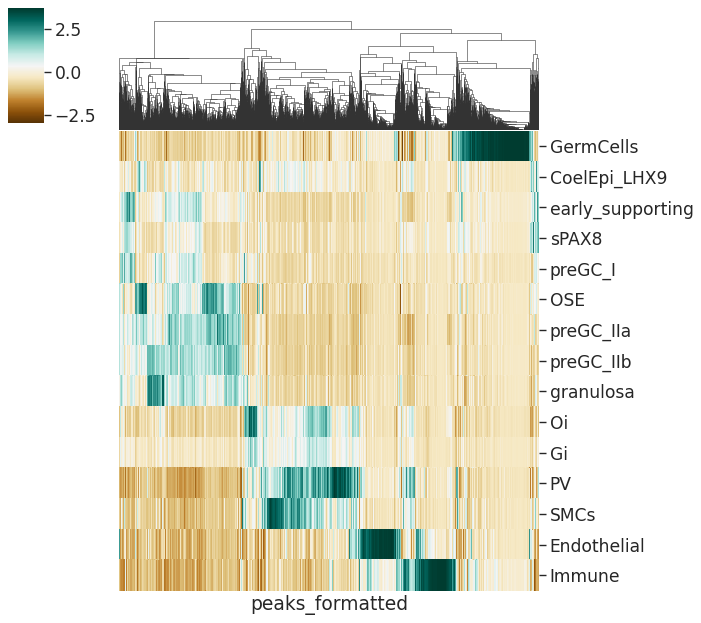

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.4)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(9, 8),
                         cmap = "BrBG")
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_females/heatmap_females_INTRAGONADAL_ccans_green.pdf")

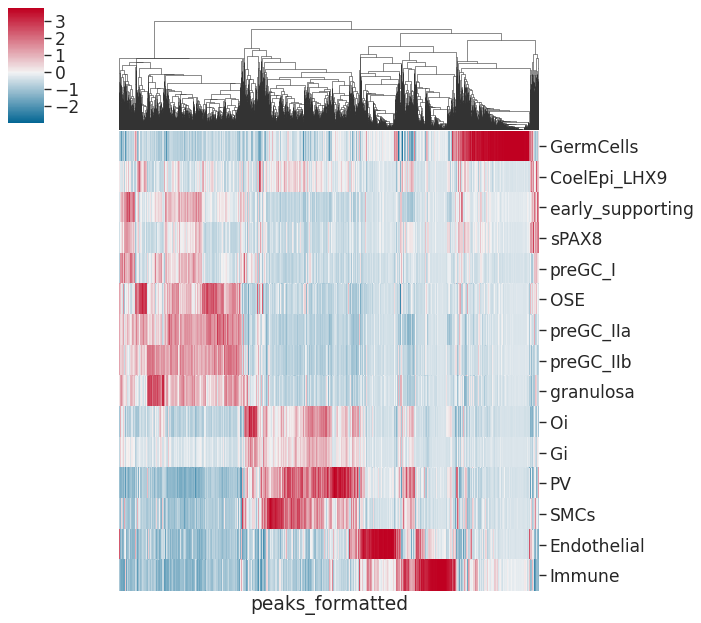

In [44]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.4)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(9, 8),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_females/heatmap_females_INTRAGONADAL_ccans.pdf")

### UMAP embedding of CCANs

In [45]:
# Create anndata 
celltype_CCANs_zscore_transposed = celltype_CCANs_zscore.transpose()
ccans_adata = anndata.AnnData(X = celltype_CCANs_zscore_transposed)
ccans_adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4190 × 15

In [46]:
sc.pp.neighbors(ccans_adata, random_state= 123)
sc.tl.umap(ccans_adata)

In [47]:
ccans_adata.obs['female_value'] = ccans_adata.X.argmax(axis=1)

In [48]:
ccans_adata.obs['female_value'].value_counts(dropna = False)

0     752
11    601
14    490
13    449
12    372
5     334
6     257
8     249
9     209
7     175
2     128
4      73
3      55
1      38
10      8
Name: female_value, dtype: int64

In [49]:
supporting_cluster = {0 :'GermCells', 1 : 'CoelEpi_LHX9', 2 : 'early_supporting', 
                      3 :'sPAX8', 4 : 'preGC_I', 5 : 'OSE', 6 : 'preGC_IIa', 7 : 'preGC_IIb', 8 : 'granulosa',
                    9 : 'Oi', 10 : 'Gi', 11 :  'PV', 12 : 'SMCs', 13 : 'Endothelial', 
                      14 : 'Immune'}
ccans_adata.obs['clusters'] = ccans_adata.obs['female_value'].map(supporting_cluster)
ccans_adata.obs['clusters'].value_counts(dropna = False)

GermCells           752
PV                  601
Immune              490
Endothelial         449
SMCs                372
OSE                 334
preGC_IIa           257
granulosa           249
Oi                  209
preGC_IIb           175
early_supporting    128
preGC_I              73
sPAX8                55
CoelEpi_LHX9         38
Gi                    8
Name: clusters, dtype: int64

... storing 'clusters' as categorical


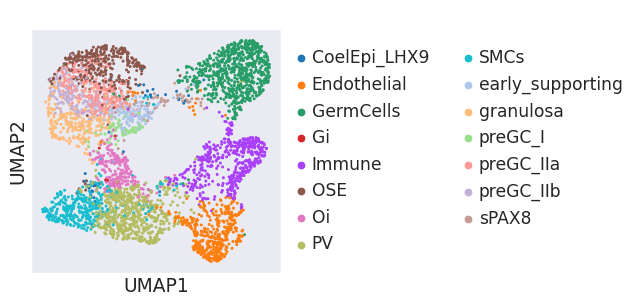

In [50]:
sc.pl.umap(ccans_adata, color = 'clusters', title = " ", frameon = True,  outline_color = ('black', 'white'),
           save = '_CCAN_embedding')


<AxesSubplot:>

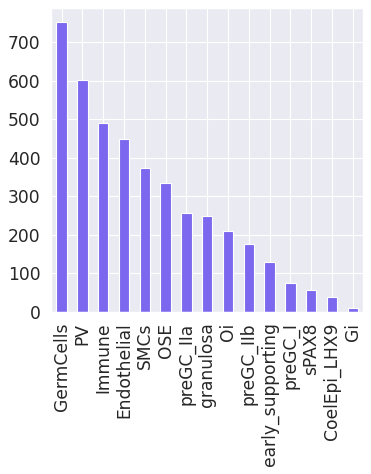

In [51]:
ccans_adata.obs['clusters'].value_counts().plot(kind='bar', figsize=(5, 5), rot=90, color = 'mediumslateblue')

In [52]:
peaks_mapping_numbers = {}
for k in peaks_mapping:
    peaks_mapping_numbers[str(k)] = len(peaks_mapping[k])

In [53]:
ccans_adata.obs['n_peaks'] = ccans_adata.obs_names.map(peaks_mapping_numbers)

In [54]:
plot_dict = {}
for i in np.unique(ccans_adata.obs['clusters']):
    print(i)
    plot_dict[i] = 0
    for index, row in ccans_adata.obs[ccans_adata.obs['clusters']==i].iterrows():
        plot_dict[i] += row['n_peaks']

CoelEpi_LHX9
Endothelial
GermCells
Gi
Immune
OSE
Oi
PV
SMCs
early_supporting
granulosa
preGC_I
preGC_IIa
preGC_IIb
sPAX8


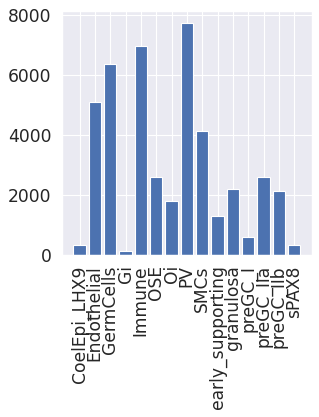

In [55]:
import matplotlib.pyplot as plt
plt.bar(range(len(plot_dict)), plot_dict.values(), align='center')
plt.xticks(range(len(plot_dict)), list(plot_dict.keys()), rotation = 90)

plt.show()

### Show enrichment of CCAN containing causal SNPs for PCOS 

In [56]:
import pybedtools

In [58]:
## Save ccans as bed files 
for c in np.unique(ccans['CCAN']):
    ccan = ccans[ccans['CCAN'] == c]
    chrom = ccan['Peak'][1].split("-")[0] # Save chromosome information
    peaks = []
    for p in ccan['Peak'].to_list():
        p_start = p.split("-")[1]
        peaks.append(int(p_start))
        p_end = p.split("-")[2]
        peaks.append(int(p_end))
    peaks.sort()
    start = peaks[0]
    end = peaks[len(peaks)-1]
    #print("CCAN {}: {}-{}-{}".format(c, chrom, start, end))
    bed_dict = {'chrom' : chrom, 'chromStart' : start, 'chromEnd' : end}
    bed_df = pd.DataFrame(bed_dict, index=[0])
    pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/beds_ccans/" + "ccan_" + str(c) + ".bed", 
                                     index=False, sep='\t')

In [118]:
# Check CCAN:
ccans[ccans['CCAN'] == 6806]

Peak  CCAN  peak_width  exon  \
peaks_formatted                                                          
chr8-11456493-11457418  chr8-11456493-11457418  6806         926     0   
chr8-11491881-11492476  chr8-11491881-11492476  6806         596     0   
chr8-11557958-11559064  chr8-11557958-11559064  6806        1107     1   
chr8-11783315-11783780  chr8-11783315-11783780  6806         466     1   
chr8-11858638-11859031  chr8-11858638-11859031  6806         394     0   
chr8-11862249-11863064  chr8-11862249-11863064  6806         816     1   
chr8-11877525-11878238  chr8-11877525-11878238  6806         714     0   
chr8-11878503-11878927  chr8-11878503-11878927  6806         425     0   
chr8-11879374-11879864  chr8-11879374-11879864  6806         491     0   
chr8-11886983-11887567  chr8-11886983-11887567  6806         585     0   
chr8-11887678-11888431  chr8-11887678-11888431  6806         754     0   
chr8-11896506-11897683  chr8-11896506-11897683  6806        1178     0   

                                gene_id  gene gene_name  annotation  promoter  \
peaks_formatted                                                                 
chr8-11456493-11457418  ENSG00000154319     1   FAM167A      intron         0   
chr8-11491881-11492476  ENSG00000136573     0       BLK    promoter         1   
chr8-11557958-11559064  ENSG00000136573     1       BLK        exon         1   
chr8-11783315-11783780  ENSG00000154328     1     NEIL2        exon         0   
chr8-11858638-11859031  ENSG00000164733     1      CTSB      intron         0   
chr8-11862249-11863064  ENSG00000164733     1      CTSB        exon         1   
chr8-11877525-11878238              NaN     0       NaN  intergenic         0   
chr8-11878503-11878927              NaN     0       NaN  intergenic         0   
chr8-11879374-11879864              NaN     0       NaN  intergenic         0   
chr8-11886983-11887567              NaN     0       NaN  intergenic         0   
chr8-11887678-11888431              NaN     0       NaN  intergenic         0   
chr8-11896506-11897683              NaN     0       NaN  intergenic         0   

                        tss_distance  ENCODE_blacklist  
peaks_formatted                                         
chr8-11456493-11457418          9316                 0  
chr8-11491881-11492476          1524                 0  
chr8-11557958-11559064          1268                 0  
chr8-11783315-11783780           702                 0  
chr8-11858638-11859031          3436                 0  
chr8-11862249-11863064             0                 0  
chr8-11877525-11878238          8076                 0  
chr8-11878503-11878927          9054                 0  
chr8-11879374-11879864          9925                 0  
chr8-11886983-11887567         17534                 0  
chr8-11887678-11888431         18229                 0  
chr8-11896506-11897683         27057                 0

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

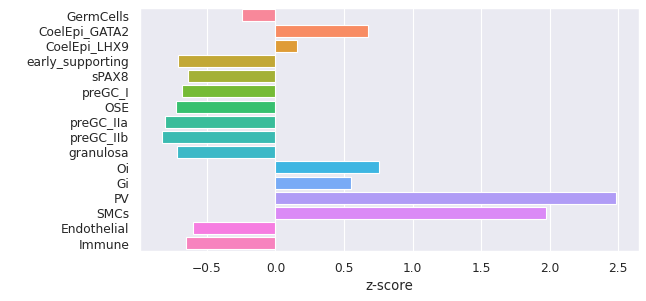

In [103]:
# 890 --> 1 SNP (ZNF438)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[890], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

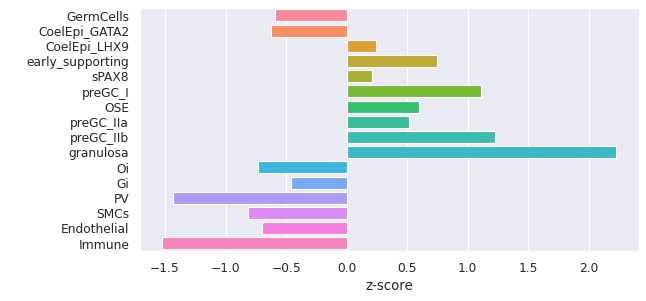

In [108]:
# 7410 --> 3 SNP (FANCC)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[7410], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

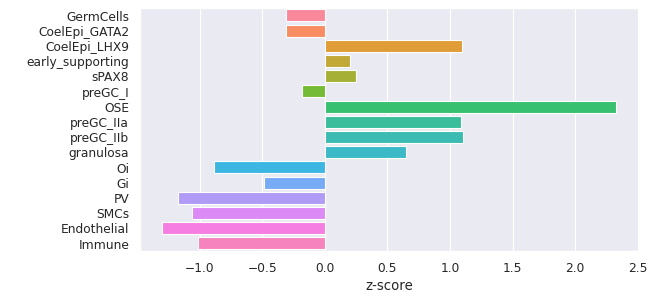

In [113]:
# 7175 --> 3 SNP (DANDD1)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[7175], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

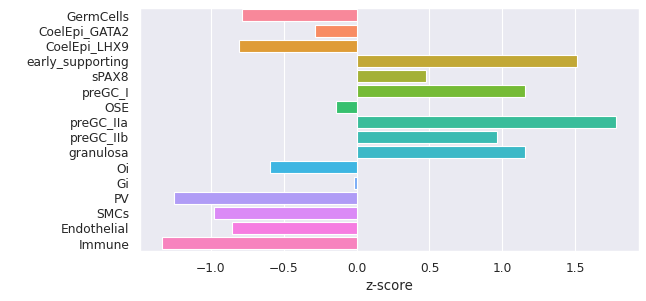

In [117]:
# 6860 --> 1 SNP (no genes)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6860], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

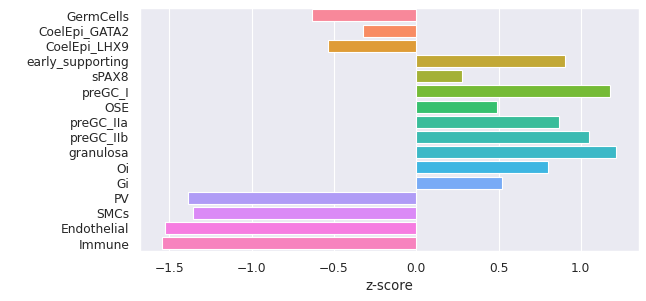

In [120]:
# 6798 --> 2 SNP (no genes)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6798], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

[Text(0.5, 0, 'z-score'), Text(0, 0.5, ' ')]

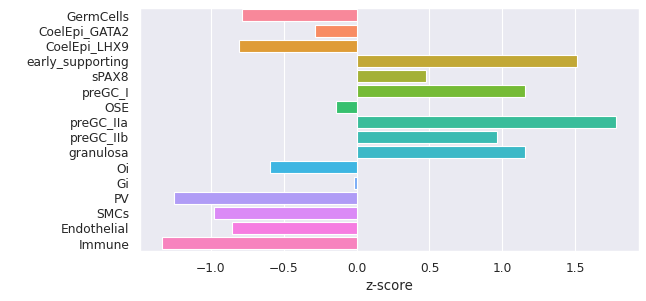

In [157]:
# 65 --> 1 SNP (no genes)
sns.set(rc={'figure.figsize':(8,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[6860], y = celltype_CCANs_zscore.index, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')

1746 --> 2 SNPs
65 --> 1 SNP 
6460 --> 1 SNP 
1720 --> 1 SNP
1698 --> 3 SNPs
1156 --> 2 SNPs
4108 --> 1 SNP
3899 --> 4 SNP
3785 --> 1 SNP
3713 --> 1 SNP
3572 --> 1 SNP
3403 --> 1 SNP
2918 --> 1 SNP
2677 --> 2 SNP
2634 --> 1 SNP 
247 --> 1 SNP 
4670 --> 1 SNP 
4199 --> 1 SNP 
5567 --> 1 SNP 
6860 --> 1 SNP 

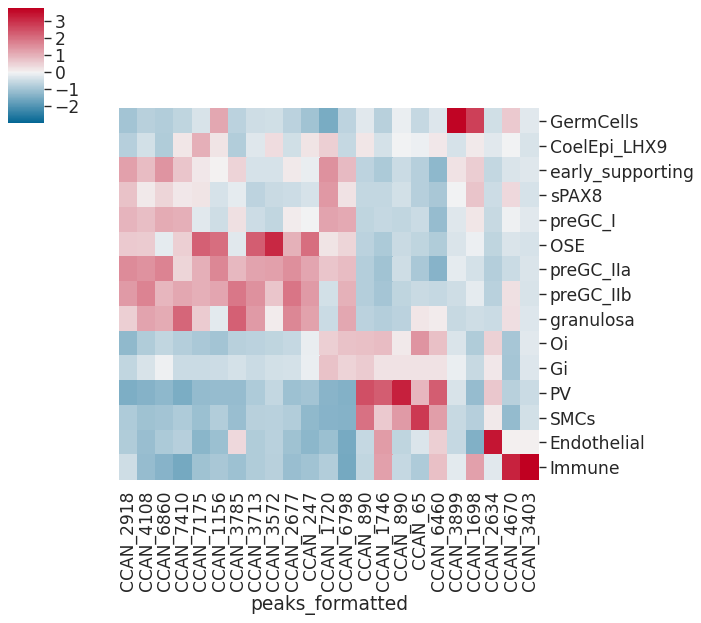

In [59]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.4)

heatmap = sns.clustermap(celltype_CCANs_zscore[[2918, 4108, 6860, 7410, 7175, 1156, 3785, 3713, 3572, 2677,
                                              247,  1720, 6798,890, 1746, 65, 6460, 3899,
                                               1698, 2634, 4670, 3403, 4199]], row_cluster=False,col_cluster = False,
                         annot=False, xticklabels = ['CCAN_2918', 'CCAN_4108', 
                        'CCAN_6860', 'CCAN_7410', 'CCAN_7175', 'CCAN_1156', 'CCAN_3785', 'CCAN_3713', 
                        'CCAN_3572', 'CCAN_2677', 'CCAN_247',  'CCAN_1720', 'CCAN_6798','CCAN_890',
                        'CCAN_1746', 'CCAN_890', 'CCAN_65', 'CCAN_6460', 'CCAN_3899', 'CCAN_1698', 
                                                    'CCAN_2634', 'CCAN_4670', 'CCAN_3403', 'CCAN_4199'], yticklabels = 'auto',  figsize=(9, 8),
                         cmap = my_cmap, norm = divnorm)
plt.setp(heatmap.ax_heatmap.get_xticklabels(), rotation=90)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_females/heatmap_females_INTRAGONADAL_ccans_PCOS.pdf")

## Save peaks as BED files

In [60]:
# Make a dictionary mapping cell type to set of CCANs enriched in that cell type  
cell_ccan_mapping = ccans_adata.obs.groupby('clusters').groups
#cell_ccan_mapping

In [62]:
# Create a list of lists containing the peaks associated to each cell type
cell_types = ['GermCells',
                                                 'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I',
                                                 'OSE','preGC_IIa', 'preGC_IIb', 'granulosa',
                                                  'Oi',  'Gi', 
                                                 'PV', 'SMCs', 'Endothelial', 'Immune']
big_list = []
for cell_type in cell_types: 
    ccan_list = list(cell_ccan_mapping[cell_type])
    cell_type_peaks = []
    for ccan in ccan_list: 
        ccan_int = int(ccan)
        ccan_peaks = list(peaks_mapping[ccan_int])
        cell_type_peaks.extend(ccan_peaks)
    print("{}: {} associated CCANs --> {} peaks".format(cell_type, len(ccan_list), 
                                                                                  len(cell_type_peaks)))
    big_list.append(cell_type_peaks)

GermCells: 752 associated CCANs --> 6373 peaks
CoelEpi_LHX9: 38 associated CCANs --> 330 peaks
early_supporting: 128 associated CCANs --> 1296 peaks
sPAX8: 55 associated CCANs --> 319 peaks
preGC_I: 73 associated CCANs --> 575 peaks
OSE: 334 associated CCANs --> 2589 peaks
preGC_IIa: 257 associated CCANs --> 2580 peaks
preGC_IIb: 175 associated CCANs --> 2113 peaks
granulosa: 249 associated CCANs --> 2198 peaks
Oi: 209 associated CCANs --> 1783 peaks
Gi: 8 associated CCANs --> 126 peaks
PV: 601 associated CCANs --> 7734 peaks
SMCs: 372 associated CCANs --> 4118 peaks
Endothelial: 449 associated CCANs --> 5099 peaks
Immune: 490 associated CCANs --> 6974 peaks


In [63]:
# Remove peaks belonging to sex chromosomes X and Y 
big_list_somatic = []
for sublist in big_list: 
    sublist_somatic = [i for i in sublist if "X" not in i and "Y" not in i]
    big_list_somatic.append(sublist_somatic)

In [64]:
# Create a dataframe for each cell type containing chrom, chromStart, chromEnd for each peak 
bed_df_list = []
for sublist_somatic in big_list_somatic: 
    chrom = [i.split("-")[0] for i in sublist_somatic] # need to remove chr prefix
    chromStart = [int(i.split("-")[1]) for i in sublist_somatic]
    chromEnd = [int(i.split("-")[2]) for i in sublist_somatic]
    bed_dict = {'chrom' : chrom, 'chromStart' : chromStart, 'chromEnd' : chromEnd}
    bed_df = pd.DataFrame(bed_dict)
    #bed_df = bed_df.set_index('chrom')
    bed_df_list.append(bed_df)

In [65]:
len(bed_df_list)

15

In [60]:
import pybedtools

In [67]:
for idx in range(15):
    cell_type = cell_types[idx]
    print(cell_type)
    bed_df = bed_df_list[idx]
    pybedtools.BedTool.from_dataframe(bed_df, 
                outfile = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/beds_intragonadal/" + cell_type + ".bed", 
                                     index=False, sep='\t')

GermCells
CoelEpi_LHX9
early_supporting
sPAX8
preGC_I
OSE
preGC_IIa
preGC_IIb
granulosa
Oi
Gi
PV
SMCs
Endothelial
Immune


#### End of notebook